In [29]:
import dask
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib.ticker import FormatStrFormatter

dask.config.set(scheduler = "single-threaded")

In [4]:
# Load data sets
# --------------------------------------

ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpdlprofwind4newsC1.c1.*.nc',   combine='by_coords', parallel = True)
ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flxwindC1.b1.*.nc',        combine='by_coords', parallel = True)
ds3 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpinterpolatedsondeC1.c1.*.nc', combine='by_coords', parallel = True)
ds4 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flx60mC1.b1.*.nc',         combine='by_coords', parallel = True)

In [5]:
# Get reference dates from each data set
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
ref_date2 = np.datetime64(datetime(pd.to_datetime(ds2.time[0].values).year, pd.to_datetime(ds2.time[0].values).month, pd.to_datetime(ds2.time[0].values).day))
ref_date3 = np.datetime64(datetime(pd.to_datetime(ds3.time[0].values).year, pd.to_datetime(ds3.time[0].values).month, pd.to_datetime(ds3.time[0].values).day))
ref_date4 = np.datetime64(datetime(pd.to_datetime(ds4.time[0].values).year, pd.to_datetime(ds4.time[0].values).month, pd.to_datetime(ds4.time[0].values).day))

In [6]:
# Ensure reference dates match
# --------------------------------------

assert(ref_date1 == ref_date2)
assert(ref_date1 == ref_date3)
assert(ref_date1 == ref_date4)

In [7]:
# Compute new time axis
# --------------------------------------

ds1['time'] = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values
ds2['time'] = ((ds2.time - ref_date2) / np.timedelta64(1, 'D')).values
ds3['time'] = ((ds3.time - ref_date3) / np.timedelta64(1, 'D')).values
ds4['time'] = ((ds4.time - ref_date4) / np.timedelta64(1, 'D')).values

In [8]:
# Get interpolation values
# --------------------------------------

min_date = max([ds1['time'][0],  ds2['time'][0],  ds3['time'][0],  ds4['time'][0]])
max_date = min([ds1['time'][-1], ds2['time'][-1], ds3['time'][-1], ds4['time'][-1]])

interval = (1 / 12) / 24

common_time = np.arange(min_date, max_date, interval)

In [9]:
ds1 = ds1.interp(time = common_time)
ds2 = ds2.interp(time = common_time)
ds3 = ds3.interp(time = common_time, height = 3000)
ds4 = ds4.interp(time = common_time)

ds_combined = xr.concat([ds2, ds1], dim = 'height')
ds_combined = ds_combined.sortby('height')

In [10]:
# Regularize data sets
# --------------------------------------

old_u = ds_combined['u'].values
old_v = ds_combined['v'].values

heights     = np.concatenate(([4], [10], np.arange(20, 2000 + 20, 20)))
old_heights = ds_combined['height'].values
new_u       = np.zeros((len(heights), ds_combined['u'].shape[1]))
new_v       = np.zeros((len(heights), ds_combined['v'].shape[1]))

for t in range(new_u.shape[1]):
    inds       = ~np.isnan(old_u[:, t])
    if any(inds == True):
        new_u[:,t] = np.interp(heights, old_heights[inds], old_u[inds, t])
        new_v[:,t] = np.interp(heights, old_heights[inds], old_v[inds, t])

qc_flag_w = np.zeros(common_time.shape)
qc_flag_s = np.zeros(common_time.shape)

total_h = len(old_heights)

surface_quantity = ds4.L.values

for t in range(common_time.shape[0]):
    qc_flag_w[t] = np.sum(np.isnan(old_u[:, t])) / total_h
    qc_flag_s[t] = ~np.isnan(surface_quantity[t])

qc_flag_w = qc_flag_w < 2/3

qc_flag = qc_flag_w * (qc_flag_s).astype(bool)

# del ds1
# del ds2
# del ds3

ds_new = xr.Dataset({
'u': xr.DataArray(
            data   = new_u[:, qc_flag],
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'v': xr.DataArray(
            data   = new_v[:, qc_flag],
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'L': xr.DataArray(
            data   = 1/(ds4.L.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'TKE': xr.DataArray(
            data   = (ds4.TKE.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'hFlux': xr.DataArray(
            data   = (ds4.sh_flux.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'mFlux': xr.DataArray(
            data   = (ds4.mom_flux.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
    })

# Average over 30min windows

ds_new = ds_new.assign_coords(time = pd.Timestamp(ref_date1) + pd.to_timedelta(ds_new.time, unit = 'D').round('min'))

ds_new = ds_new.resample(time = '30min').mean(dim = ['time'])

ds_new['time'] = ((ds_new.time - ref_date1) / np.timedelta64(1, 'D')).values

ds_new = ds_new.dropna(dim = 'time', how = 'all')

ds_new = ds_new.transpose()

# del ds_combined
del ds4
# del new_u
# del new_v

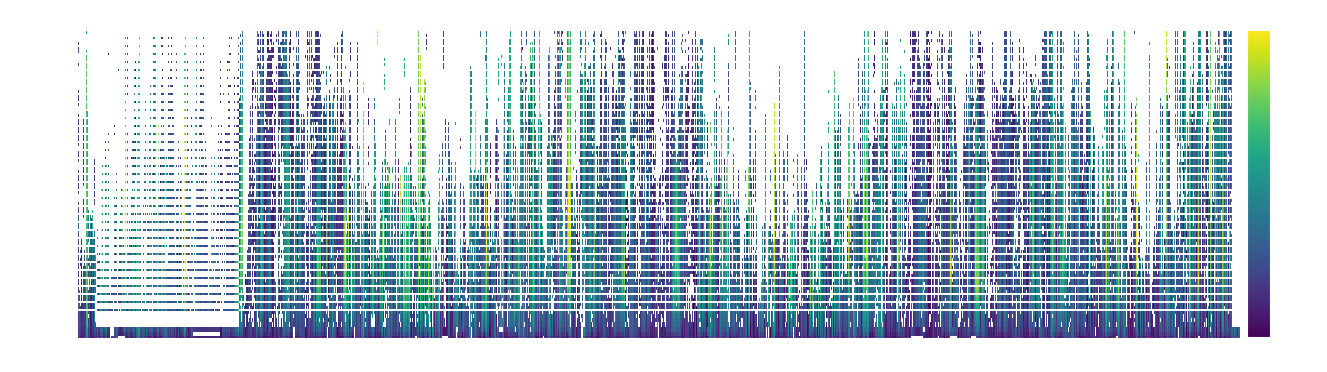

In [197]:
# Plot time-varying profiles
# --------------------------------------

fig,ax = plt.subplots(figsize = (15, 4))

cntf = ax.pcolormesh(common_time, ds_combined['height'].values, (ds_combined['u'].values**2 + ds_combined['v'].values**2)**(1/2), cmap = 'viridis', vmin = 0, vmax = 30)
# ax.set_xlabel("Time from start date [days]", color = 'w')
ax.set_ylabel("$z$ [m]", color = 'w')
ax.set_ylim([0, 2000])

cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
cbar = fig.colorbar(cntf, orientation='vertical', cax=cb_ax)
cbar.set_label('Wind speeåd [m/s]', rotation = 270, labelpad = 15, color = 'w')
cbar.outline.set_color('white')
cbar.ax.yaxis.set_tick_params(color = 'w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')

for spine in ax.spines.values():
    spine.set_edgecolor('w')

ax.set_xticks([0, 360, 725, 1090], ["2021", "2022", "2023", "2024"])
ax.set_title(f'Profiles: {ds_combined.time.shape[0]:,}', color = 'w')

ax.tick_params(axis = 'x', colors = 'w')
ax.tick_params(axis = 'y', colors = 'w')

plt.savefig('./raw_wind_timeseries.png', dpi = 700, bbox_inches = 'tight', transparent = True)

# del old_u
# del old_v


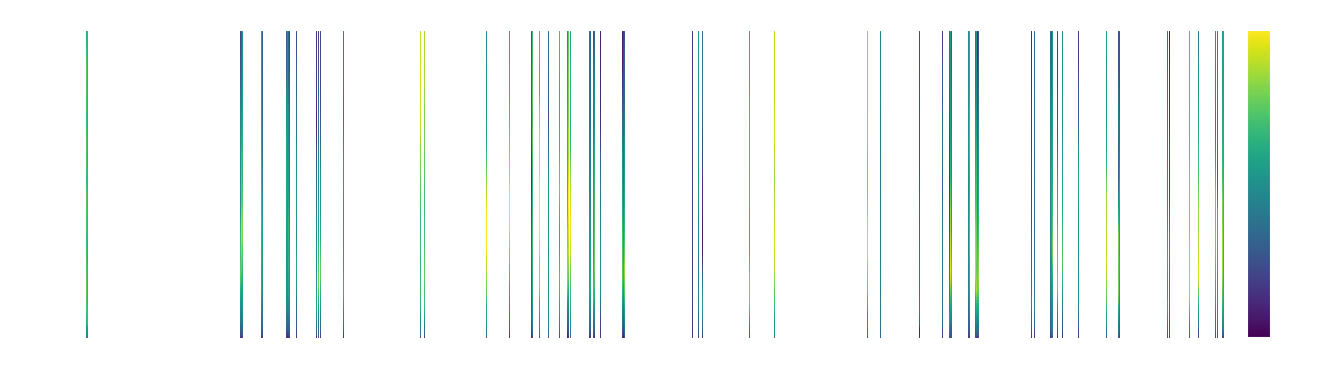

In [22]:
# Plot time-varying profiles
# --------------------------------------

fig,ax = plt.subplots(figsize = (15, 4))

# data = ((new_u**2 + new_v**2)**(1/2))

# data[:, ~qc_flag] = np.nan

# cntf = ax.pcolormesh(range(np.sum(qc_flag)), heights, data[:,qc_flag], cmap = 'viridis', vmin = 0, vmax = 30)
cntf = ax.pcolormesh(common_time, heights, data, cmap = 'viridis', vmin = 0, vmax = 30)
# ax.set_xlabel("Time from start date [days]", color = 'w')
ax.set_ylabel("$z$ [m]", color = 'w')
ax.set_ylim([0, 2000])

cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
cbar = fig.colorbar(cntf, orientation='vertical', cax=cb_ax)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15, color = 'w')
cbar.outline.set_color('white')
cbar.ax.yaxis.set_tick_params(color = 'w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')

for spine in ax.spines.values():
    spine.set_edgecolor('w')

ax.set_xticks([0, 360, 725, 1090], ["2021", "2022", "2023", "2024"])
ax.set_title(f'Profiles: {np.sum(qc_flag):,}', color = 'w')

ax.tick_params(axis = 'x', colors = 'w')
ax.tick_params(axis = 'y', colors = 'w')

plt.savefig('./qc_wind_timeseries.png', dpi = 700, bbox_inches = 'tight', transparent = True)

# del old_u
# del old_v


(0.0, 2000.0)

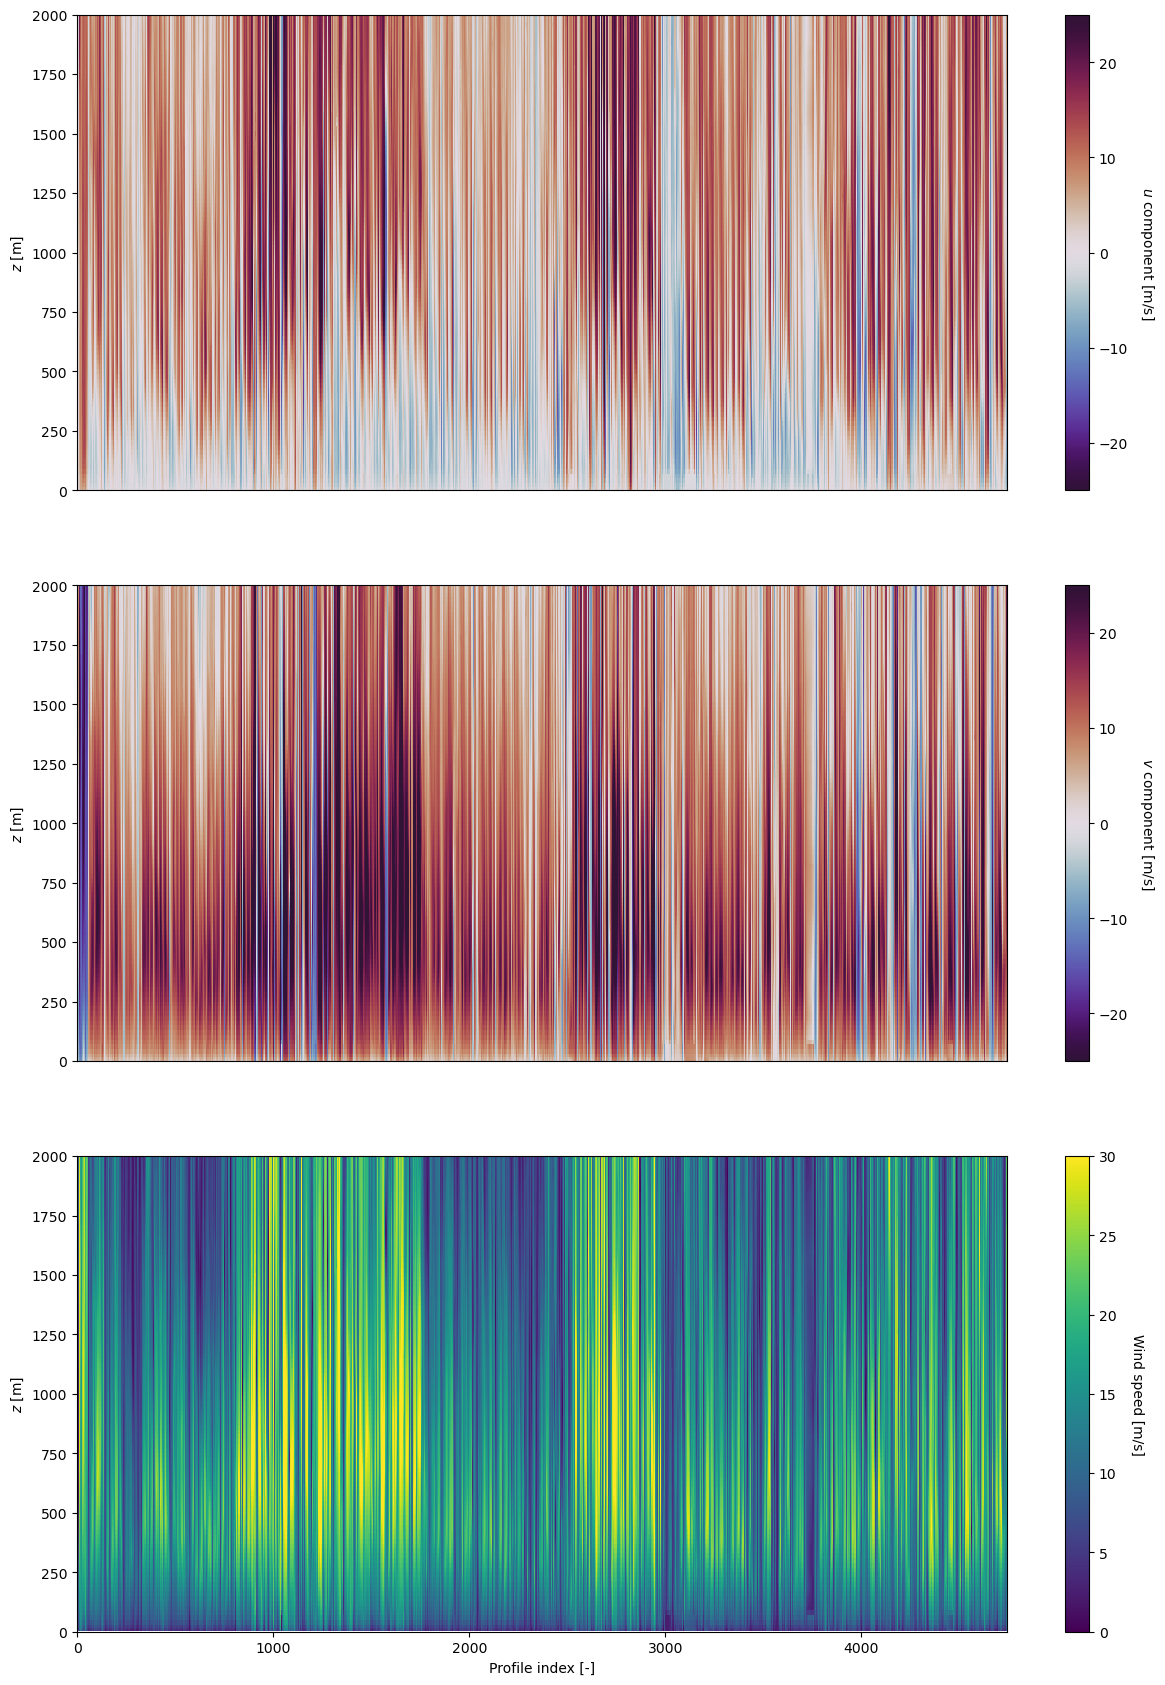

In [94]:
# Plot rectified wind profiles
# --------------------------------------

x_axis = range(len(ds_new.time))
# x_axis = ds_new.time

fig,ax = plt.subplots(3, 1, figsize = (15, 21))

cntf = ax[0].pcolormesh(x_axis, ds_new.height, ds_new.u, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
ax[0].set_ylabel("$z$ [m]")
ax[0].set_ylim([0, 2000])
ax[0].get_xaxis().set_ticks([])

cntf = ax[1].pcolormesh(x_axis, ds_new.height, ds_new.v, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
ax[1].set_ylabel("$z$ [m]")
ax[1].set_ylim([0, 2000])
ax[1].get_xaxis().set_ticks([])

cntf = ax[2].pcolormesh(x_axis, ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis')
cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[2].set_xlabel("Profile index [-]")
ax[2].set_ylabel("$z$ [m]")
ax[2].set_ylim([0, 2000])

In [26]:
sb.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

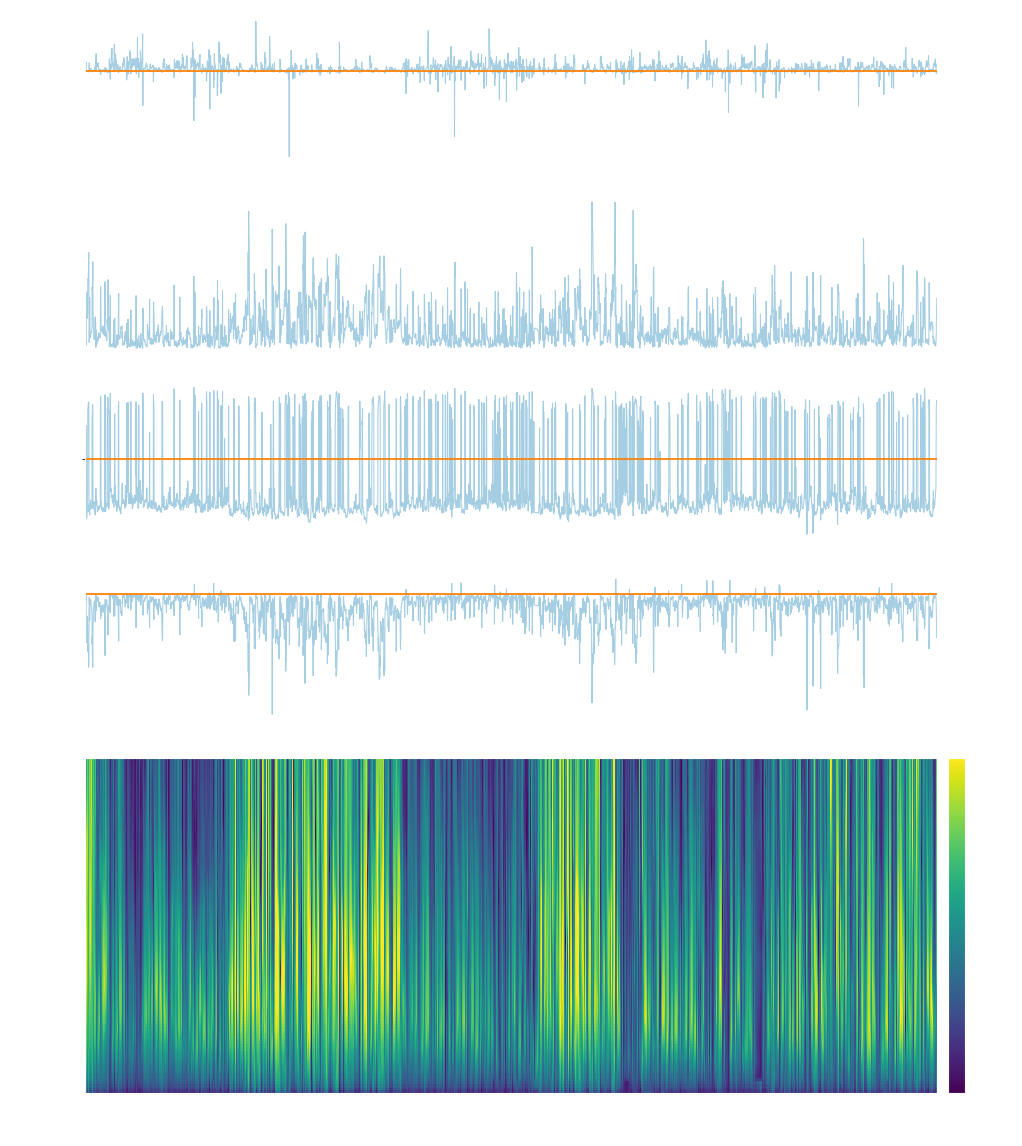

In [79]:
# Plot rectified surface quantities
# --------------------------------------

sb.color_palette("Paired")

fig,ax = plt.subplots(5, 1, figsize = (11, 14), gridspec_kw={'height_ratios': [1, 1, 1, 1, 2.25]}, sharex = True)

ax[0].plot(range(len(ds_new.time)), ds_new.L, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[0].set_ylabel("$1/L$ [m$^{-1}$]", labelpad = 6, color = 'w')
# ax[0].get_xaxis().set_ticks([])
ax[0].axhline(y = 0, color = sb.color_palette("Paired")[7], linestyle = '-', linewidth = 1.25)
# ax[0].set_ylim([-0.1, 0.1])
ax[0].set_yscale('symlog')
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax[0].grid()

ax[1].plot(range(len(ds_new.time)), ds_new.TKE, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[1].set_ylabel("TKE [m$^2$ s$^{-2}$]", labelpad = 26, color = 'w')
# ax[1].get_xaxis().set_ticks([])
ax[1].set_ylim([0, 8])
# ax[1].grid()

ax[2].plot(range(len(ds_new.time)), ds_new.hFlux, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[2].set_ylabel("Heat flux [W m$^{-2}$]", labelpad = 8, color = 'w')
# ax[2].get_xaxis().set_ticks([])
# ax[2].set_ylim([-100, 225])
ax[2].axhline(y = 0, color = sb.color_palette("Paired")[7], linestyle = '-', linewidth = 1.25)
ax[2].set_yscale('symlog')
ax[2].set_yticks([-100, -10, -1, 1, 10, 100])
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax[1].grid()

ax[3].plot(range(len(ds_new.time)), ds_new.mFlux, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[3].set_ylabel("Mom. flux [kg m$^{-1}$ s$^{-2}$]", labelpad = 4, color = 'w')
# ax[3].get_xaxis().set_ticks([])
# ax[3].set_ylim([-0.6, 0])
ax[3].axhline(y = 0, color = sb.color_palette("Paired")[7], linestyle = '-', linewidth = 1.25)
ax[3].set_yscale('symlog')
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax[1].grid()

cntf = ax[4].pcolormesh(range(len(ds_new.time)), ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis', linewidth = 0.75)
# cbar = plt.colorbar(cntf)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[4].set_xlabel("Profile index [-]", color = 'w')
ax[4].set_ylabel("$z$ [m]", labelpad = 8, color = 'w')
ax[4].set_ylim([0, 2000])

cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.239])
cbar = fig.colorbar(cntf, orientation='vertical', cax=cb_ax)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15, color = 'w')
cbar.outline.set_color('white')
cbar.ax.yaxis.set_tick_params(color = 'w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')

for spine in ax[0].spines.values():
    spine.set_edgecolor('w')
for spine in ax[1].spines.values():
    spine.set_edgecolor('w')
for spine in ax[2].spines.values():
    spine.set_edgecolor('w')
for spine in ax[3].spines.values():
    spine.set_edgecolor('w')
for spine in ax[4].spines.values():
    spine.set_edgecolor('w')

ax[0].tick_params(axis = 'x', colors = 'w')
ax[0].tick_params(axis = 'y', colors = 'w')
ax[1].tick_params(axis = 'x', colors = 'w')
ax[1].tick_params(axis = 'y', colors = 'w')
ax[2].tick_params(axis = 'x', colors = 'w')
ax[2].tick_params(axis = 'y', colors = 'w')
ax[3].tick_params(axis = 'x', colors = 'w')
ax[3].tick_params(axis = 'y', colors = 'w')
ax[4].tick_params(axis = 'x', colors = 'w')
ax[4].tick_params(axis = 'y', colors = 'w')

plt.savefig('./wind_train_set.png', dpi = 800, bbox_inches = 'tight', transparent = True)

In [ ]:
# Plot rectified surface quantities
# --------------------------------------

fig,ax = plt.subplots(5, 1, figsize = (11, 15), gridspec_kw={'height_ratios': [1, 1, 1, 1, 3]}, sharex = True)

ax[0].plot(range(len(ds_new.time)), ds_new.L)
ax[0].set_ylabel("$1/L$ [m$^{-1}$]", labelpad = -2)
# ax[0].get_xaxis().set_ticks([])
ax[0].axhline(y = 0, color = 'grey', linestyle = '--')
ax[0].set_ylim([-0.05, 0.05])
# ax[0].grid()

ax[1].plot(range(len(ds_new.time)), ds_new.TKE)
ax[1].set_ylabel("TKE [m$^2$ s$^{-2}$]", labelpad = 23)
# ax[1].get_xaxis().set_ticks([])
ax[1].set_ylim([0, 6.5])
# ax[1].grid()

ax[2].plot(range(len(ds_new.time)), ds_new.hFlux)
ax[2].set_ylabel("Heat flux [W m$^{-2}$]", labelpad = 3)
# ax[2].get_xaxis().set_ticks([])
ax[2].set_ylim([-100, 225])
ax[2].axhline(y = 0, color = 'grey', linestyle = '--')
# ax[1].grid()

ax[3].plot(range(len(ds_new.time)), ds_new.mFlux)
ax[3].set_ylabel("Mom. flux [kg m$^{-1}$ s$^{-2}$]", labelpad = 4)
# ax[3].get_xaxis().set_ticks([])
ax[3].set_ylim([-0.6, 0])
# ax[1].grid()

cntf = ax[4].pcolormesh(range(len(ds_new.time)), ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis')
# cbar = plt.colorbar(cntf)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[4].set_xlabel("Profile index [-]")
ax[4].set_ylabel("$z$ [m]", labelpad = 4)
ax[4].set_ylim([0, 2000])

cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.285])
cbar = fig.colorbar(cntf, orientation='vertical', cax=cb_ax, )
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15)

plt.savefig('./wind_model_training.png', dpi = 700, bbox_inches = 'tight', transparent = True)

Text(0.5, 1.0, 'Days from reference: 170.0')

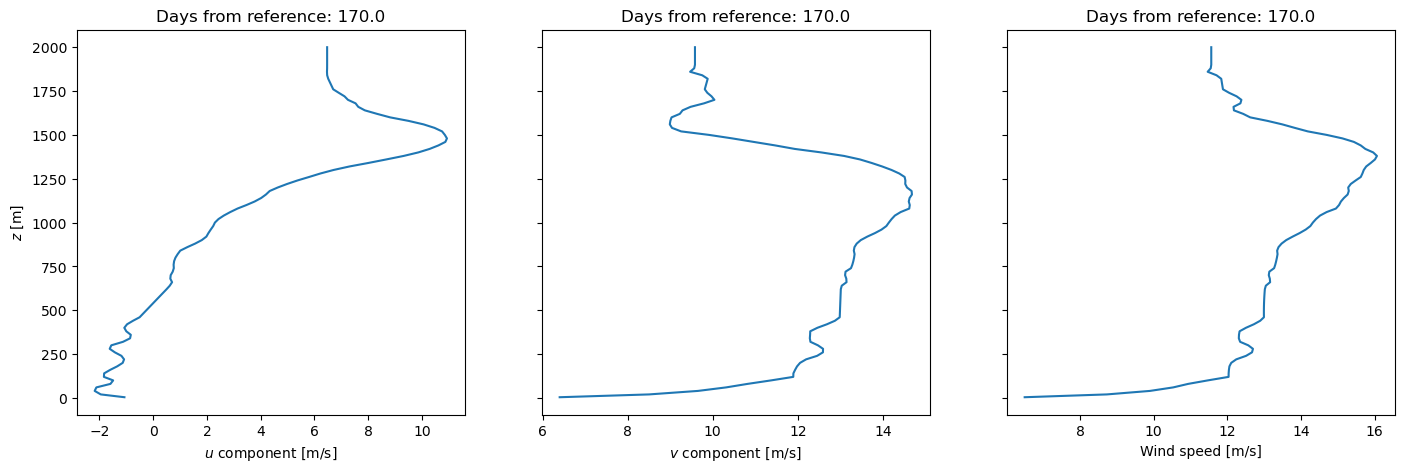

In [121]:
# Plot sample component profiles
# --------------------------------------

fig,ax = plt.subplots(1,3,figsize = (17, 5), sharey = True)

i = 88

ax[0].plot(ds_new.u[:,i], ds_new.height)
ax[0].set_xlabel('$u$ component [m/s]')
ax[0].set_ylabel('$z$ [m]')
# ax[0].set_ylim([0, 50])
ax[0].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[1].plot(ds_new.v[:,i], ds_new.height)
ax[1].set_xlabel('$v$ component [m/s]')
# ax[1].set_ylabel('$z$ [m]')
# ax[1].set_ylim([0, 50])
ax[1].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[2].plot((ds_new.u[:,i]**2 + ds_new.v[:,i]**2)**(1/2), ds_new.height)
ax[2].set_xlabel('Wind speed [m/s]')
# ax[2].set_ylabel('$z$ [m]')
# ax.set_ylim([0, 50])
ax[2].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

In [97]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(ds_new.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds_new.time.values

for i in range(ds_new.time.shape[0]):
    new_ref_times[i] = np.datetime64((pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D')).round('min'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour + pd.Timestamp(new_ref_times[i]).minute/60
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

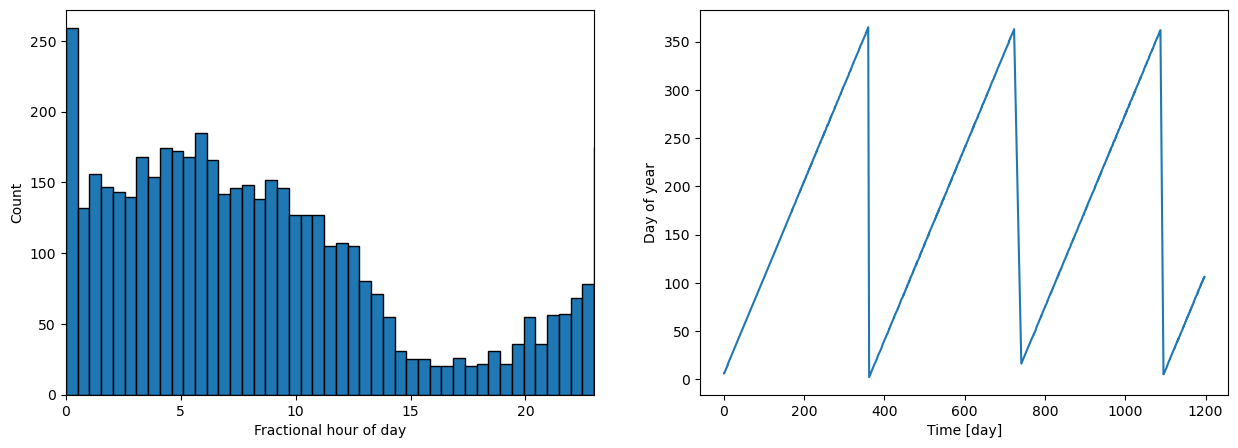

In [111]:
# Confirm time axes are correct
# --------------------------------------

fig,ax = plt.subplots(1,2,figsize = (15, 5))

# ax[0].plot(times, hr_per_day)
ax[0].hist(hr_per_day, bins = 46, edgecolor = 'black')
ax[0].set_xlim([0, 23])
# ax[0].plot(range(len(times)), hr_per_day)
ax[0].set_xlabel('Fractional hour of day')
ax[0].set_ylabel('Count')

ax[1].plot(times, day_per_yr)
# ax[1].plot(range(len(times)), day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [99]:
# Save data
# --------------------------------------

ds_new['hr_day'] = (('time'), hr_per_day)
ds_new['day_yr'] = (('time'), day_per_yr)

ds_new.to_netcdf('/Users/smata/Downloads/processedData/velocityData_30min.nc')

ds_new

<xarray.Dataset>
Dimensions:  (height: 102, time: 4743)
Coordinates:
  * height   (height) int64 4 10 20 40 60 80 ... 1900 1920 1940 1960 1980 2000
  * time     (time) float64 1.188 1.208 1.229 ... 1.197e+03 1.197e+03 1.197e+03
Data variables:
    u        (height, time) float64 -2.648 -2.706 -2.801 ... 7.017 7.972 6.151
    v        (height, time) float64 3.67 3.777 3.749 3.447 ... 21.13 23.35 22.86
    L        (time) float64 0.02723 0.02628 0.02367 ... -0.002609 -0.002158
    TKE      (time) float64 0.3693 0.3473 0.3432 0.4116 ... 2.46 2.751 2.663
    hFlux    (time) float64 -31.26 -27.36 -30.44 -36.53 ... 95.6 90.4 73.08
    mFlux    (time) float64 -0.06733 -0.06322 -0.07318 ... -0.618 -0.6054
    hr_day   (time) float64 4.5 5.0 5.5 6.0 6.5 7.0 ... 17.0 21.5 22.5 23.0 23.5
    day_yr   (time) float64 6.0 6.0 6.0 6.0 6.0 ... 106.0 106.0 106.0 106.0

Text(0, 0.5, 'Count')

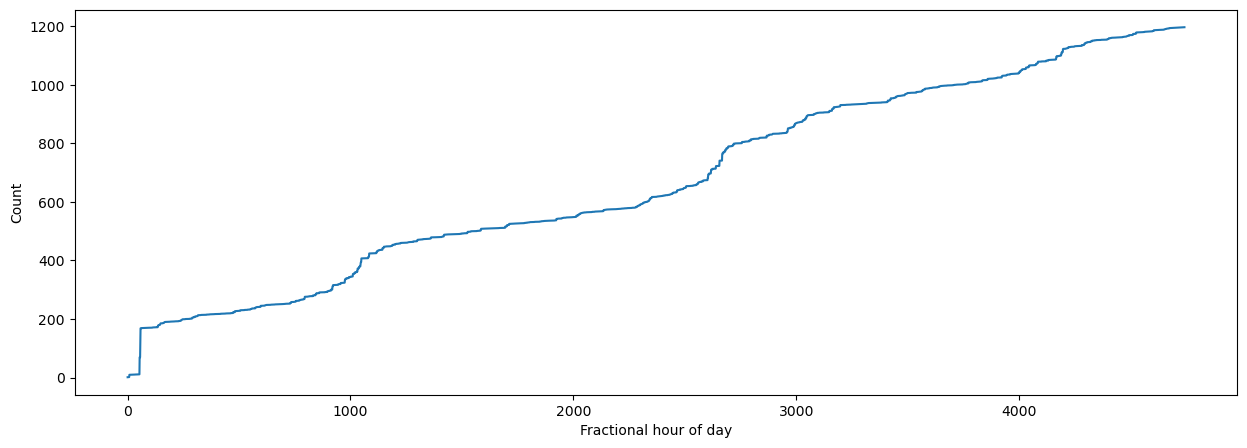

In [100]:
fig,ax = plt.subplots(figsize = (15, 5))

ax.plot(range(len(ds_new.time.values)), ds_new.time.values)
# ax.set_xlim([0, 23])
# ax[0].plot(range(len(times)), hr_per_day)
ax.set_xlabel('Fractional hour of day')
ax.set_ylabel('Count')